# Baseline

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append(r"E:\CMF\CMF_FFS/")

from src.metrics_calculation import metrics
from src.cross_val import timeseriesCVscore
from src.preprocess import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [3]:
data_dir = '../data/processed/'

In [4]:
"""
I divided the companies into 2 parts because if I didn't do it,
it would be difficult to read the names of the companies on the plot
"""

def plots(names, metr):
    plt.rcParams["figure.figsize"] = (25,10)
    
    
    plt.plot(names[:26], metr[:78:3], label='MAPE')
    plt.plot(names[:26], metr[1:78:3], label='WAPE')
    #plt.plot(names[:26], metr[2:78:3], label='MSE') # MSE takes too large values so it's better not to display it
    plt.title('First half of companies')
    plt.legend()
    plt.show()
    
    
    
    plt.plot(names[26:], metr[78::3], label='MAPE')
    plt.plot(names[26:], metr[79::3], label='WAPE')
    #plt.plot(names[26:], metr[80::3], label='MSE') # MSE takes too large values so it's better not to display it
    plt.title('Second half of companies')
    plt.legend()
    plt.show()

## Cross validation for models for each company

In [5]:
metr = np.array([])
names = []

for i in listdir(data_dir):
    data = pd.read_csv(data_dir + i)
    mape, wape, mse = timeseriesCVscore(data, LinearRegression())
    metr = np.append(metr, [[mape], [wape], [mse]])
    names.append(i[:-4])
print('Mean MAPE =', metr[::3].sum() / len(metr[::3]) )
print('Mean WAPE =', metr[1::3].sum() / len(metr[1::3]) )
print('Mean MSE =', metr[2::3].sum() / len(metr[2::3]) )

    

Mean MAPE = 0.9233484995076894
Mean WAPE = 0.8119444057367986
Mean MSE = 1517031.9738215865


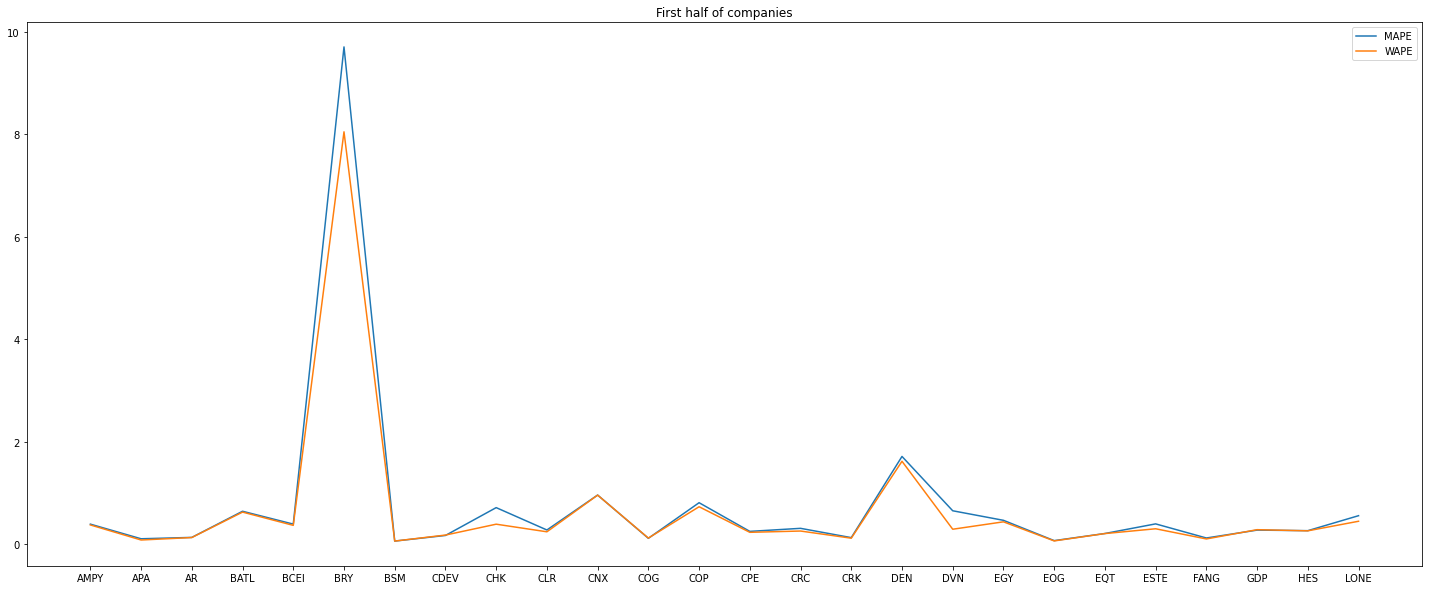

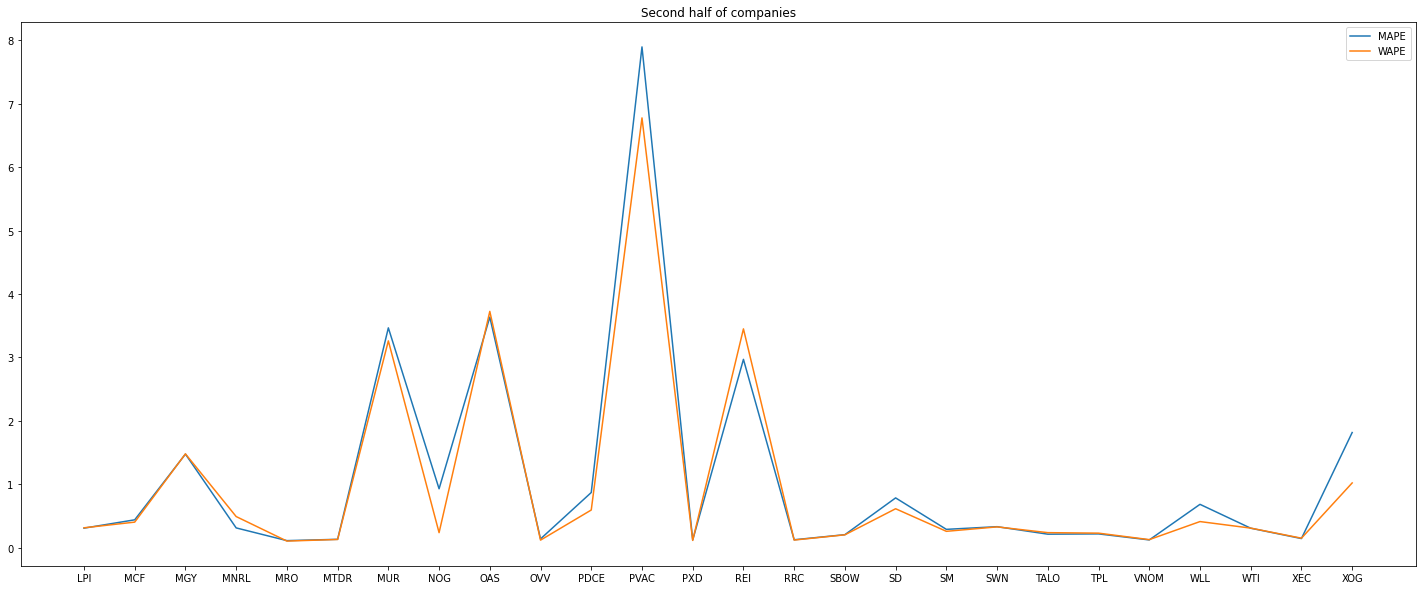

In [6]:
plots(names, metr)

## Let's create models for each company and check metrics(No cross validation)

In [7]:
y_list = []
pred_list = []
features_list = []
for i in listdir(data_dir):
    data = pd.read_csv(data_dir + i)
    data['Equity Charge'] = [i for i in range(len(data['Equity Charge']))]
    y = data['Revenue']
    data.drop(columns=['Revenue'], inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=38, shuffle=False, random_state=1)
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    model = LinearRegression(n_jobs=-1)

    model.fit(x_train_scaled, y_train)
    predictions = model.predict(x_test_scaled)
    y_list.append(y_test)
    pred_list.append(predictions)
    
m1 = metrics(y_list, pred_list, one_model=False)
print('Mean MAPE =', m1[0])
print('Mean WAPE =', m1[1])
print('Mean MSE =', m1[2])

Mean MAPE = 0.7423965822885759
Mean WAPE = 0.7422031730386193
Mean MSE = 1835884.3550224716


## What if we want to make 1 model for each companies(No cross validation)

In [8]:
x_train_concat, x_test_concat, y_train_concat, y_test_concat = [pd.DataFrame()] * 4


for i in listdir(data_dir):
    data = pd.read_csv(data_dir + i)
    data['Equity Charge'] = [i for i in range(len(data['Equity Charge']))]
    y = data['Revenue']
    data.drop(columns=['Revenue'], inplace=True)
    x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=38, shuffle=False, random_state=1)
    x_train_concat = pd.concat([x_train_concat, x_train])
    x_test_concat = pd.concat([x_test_concat, x_test])
    y_train_concat = pd.concat([y_train_concat, y_train])
    y_test_concat = pd.concat([y_test_concat, y_test])
    
    scaler = StandardScaler()
    scaler.fit(x_train_concat)
    
    x_train_concat_scaled = scaler.transform(x_train_concat)
    x_test_concat_scaled = scaler.transform(x_test_concat)

model = LinearRegression(n_jobs=-1)
model.fit(x_train_concat_scaled, y_train_concat)
pred = model.predict(x_test_concat_scaled)

m2 = metrics(y_test_concat, pred)
print('MAPE =', m2[0])
print('WAPE =', m2[1])
print('MSE =', m2[2])

MAPE = 47492190.67364573
WAPE = 0    5.894235e+06
dtype: float64
MSE = 1.5235687980879653e+21
